# 1) Setup

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats
from copy import copy
import time
import yaml
import networkx as nx

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [3]:
#import functions from python files

#1) data import & filtering
from get_data import *
from filter_data1 import *
from filter_data2 import *
from filter_data3 import *
from select_data import *
from select_data_edge import *

#2) Bayesian: lognormal
from Gamma import *
from Lognormal import *

from Gaussian import *
from Gaussian_broadcast import *

from Normal_Gamma import *
from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *

#for comparison
from Gaussian_ml import *

from error_mae import *
from error_mse import *

from integrate_pdf import *
from error_ks import *                 #Kolmogorov-Smirnov
from error_ks_2samples import *
from error_cvm import *                #Cramer Von-Mises

#3) Bayesian: Inverse Gamma - method 1
from Inverse_Gamma import *
from Inverse_Gamma_bayes import *
from Inverse_Gamma_bayes2 import *

from Inverse_Digamma_bounds import *
from Inverse_Digamma_newton import *

#4) Bayesian: Inverse Gamma - method 2
from Inverse_Gamma_broadcast import *
from Inverse_Gamma_prior import *
from Inverse_Gamma_bayes3 import *

#5) Bayesian: Inverse Gaussian
from Inverse_Gaussian import *
from Inverse_Gaussian_broadcast import *
from Inverse_Gaussian_prior import * 
from Inverse_Gaussian_bayes import * 

#6) Comparing edges
from underscore_prefix import *
from underscore_suffix import *
from ks_between_edges import *
from get_context import *
from augment_with_context import *

#7) Network visualisation
from draw_graph import *


print("done")

done


In [4]:
# load from excel (see FILTER.ipynb)
df = pd.read_excel("filtered_data_random.xlsx")
df = df.loc[:,["origin", "target", "edge_id", "operation_time"]]
    
print("done")

done


In [5]:
count = df["edge_id"].value_counts()
count.to_csv('waypoint_pairs_random.csv')          #save and reload for DataFrame format
count = pd.read_csv("waypoint_pairs_random.csv")
count.columns = ["edge_id", "samples"]      #rename columns
count.head()

,edge_id,samples
0,WayPoint68_WayPoint61,366
1,WayPoint61_WayPoint54,349
2,WayPoint75_WayPoint68,320
3,WayPoint54_WayPoint47,303
4,WayPoint47_WayPoint40,268


# 2) Lognormal model
- if X is lognormally distributed, then ln(X) is normally distributed

## 2a) Fit using Bayesian optimisation
- Bayesian method uses an offset on the t-axis to allow the distribution to have greater skew. This operates in a similar fashion to a hard minimum t-value

In [6]:
# Select data of interest
wp1 = "WayPoint75"
wp2 = "WayPoint68"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]
print("done")

done


MAP mean: 0.20800000000000002     MAP var: 0.253
Offset: 8.124611594462808
Time for calculation: 41.09074139595032 secs


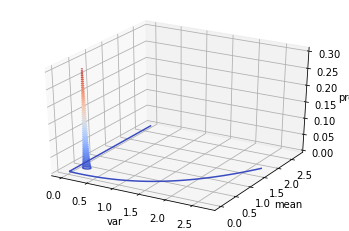

In [11]:
#use offset and take log of data
context = get_context("walmart_map.yaml")
length = context.loc[context["edge_id"] == edge]["edge_length"]
offset= np.min([float(length / (0.55 * 1.1) ), np.min(t_op) - 0.01])
#offset = np.min(t_op) - 0.01
#offset = 0
t_log = np.log(t_op - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]


#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map, "    MAP var:", var_map)
print("Offset:", offset)
print("Time for calculation:", toc-tic, "secs")

## 2b) Fit using MLE & Scipy for comparison

In [12]:
#compare to MLE mean & var
mean_ml, var_ml = Gaussian_ml(t_log)
print("MLE mean:", mean_ml, "    MLE var", var_ml)
#compare to scipy fit
shape, loc, scale = sp.stats.lognorm.fit(t_op)
print("Scipy fit params:", shape,loc,scale)

MLE mean: 0.18969419857087141     MLE var 0.2530157709076678
Scipy fit params: 0.6548897406966443 8.431381327288967 0.858755487831639


## 2c) Plot against actual data

C:\Users\pyliu\Documents\GOALS\Code\Wk4\Lognormal.py:30: RuntimeWarning: invalid value encountered in log
  exponent = (-1/(2*var)) * np.square( np.log(x)-mean )


Text(0.5, 1.0, 'WayPoint75_WayPoint68')

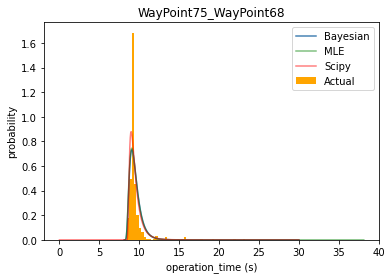

In [20]:
#Plot against actual data

t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Lognormal(t_test-offset,mean_map,var_map)
p_ml = Lognormal(t_test,mean_ml,var_ml)
p_sp = sp.stats.lognorm.pdf(t_test, s = shape,loc = loc,scale = scale)

#plot
plt.plot(t_test,p_bayes, color = "steelblue", alpha = 1)
plt.plot(t_test+offset,p_ml, color = "green", alpha = 0.5)
plt.plot(t_test,p_sp, color = "red", alpha = 0.5)
plt.hist(t_op, density = True, bins = 50, color = "orange")

#plt.legend(["Bayesian", "Actual"])
plt.legend(["Bayesian", "MLE","Scipy","Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge)

## 2d) ks test

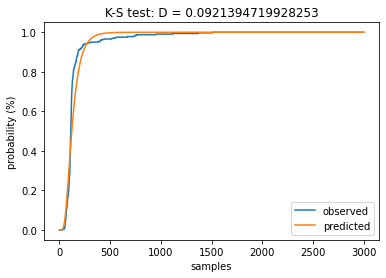

In [228]:
#ks test comparison
ks_bayes = error_ks(t_test+offset,p_bayes, t_op)

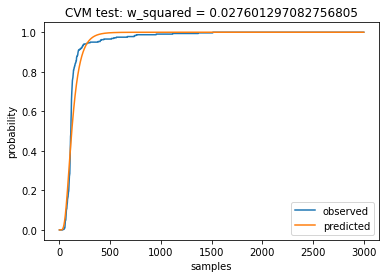

In [229]:
#cvm test comparison
cvm_bayes = error_cvm(t_test+offset,p_bayes, t_op)

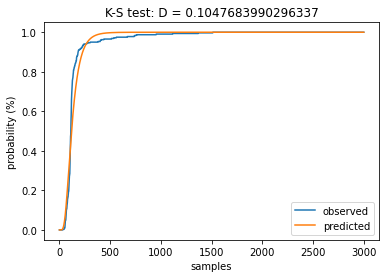

In [230]:
ks_ml = error_ks(t_test+offset,p_ml, t_op)

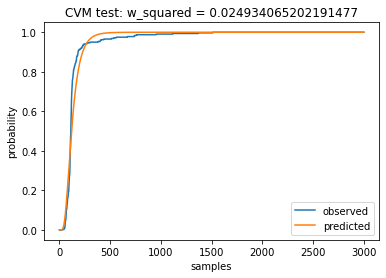

In [231]:
#cvm test comparison
cvm_ml = error_cvm(t_test+offset,p_ml, t_op)

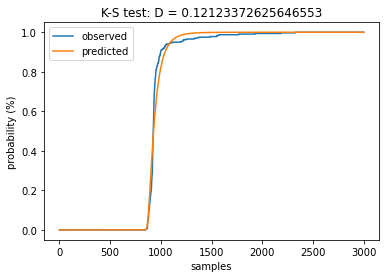

In [232]:
ks_sp = error_ks(t_test,p_sp, t_op)

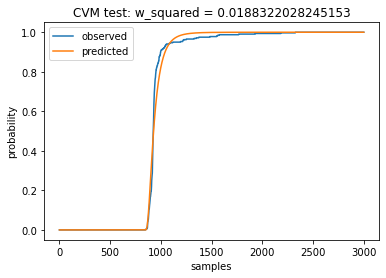

In [233]:
#cvm test comparison
cvm_sp = error_cvm(t_test,p_sp, t_op)

# 3) Inverse Gamma model
- See Llera_InverseGamma for Bayesian estimator of Invgamma parameters
- See Batir_InverseDigammaBounds for lower bound of Inverse Digamma

Brief notes:
- The only advantage compared to lognormal is the speed of estimation. 
- However, the fit is bad using the estimation methods below.
- Scipy has an MLE fit that works well. 
- Maybe that we could write a program without estimation that makes better estimates of the parameters

In [101]:
# Select data of interest
wp1 = "WayPoint68"
wp2 = "WayPoint61"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]
print("done")

done


## 3a) No offset

count: 1229
count: 2
750599937895083.1 8094922179423163.0
nan nan


C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma_bayes2.py:53: RuntimeWarning: invalid value encountered in log
  k1 = n*( np.mean( -np.log(x) ) - sp.special.digamma(alpha) + np.log(n*alpha) - np.log(np.sum(1/x)) - alpha * sp.special.polygamma(1,alpha) + 1)
C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma.py:30: RuntimeWarning: overflow encountered in double_scalars
  norm_const = (beta**alpha) / gamma_const
C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma.py:30: RuntimeWarning: invalid value encountered in double_scalars
  norm_const = (beta**alpha) / gamma_const
C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma.py:32: RuntimeWarning: overflow encountered in power
  return norm_const * x ** (-alpha - 1) * np.exp(exponent)


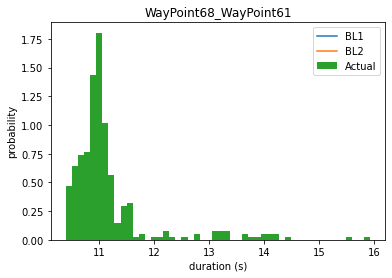

In [102]:
#Plot against actual data
t_obs = t_op 

t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#prior hyperparameters
a = 0.1
b = 1
c = 2
d = 0.3
e = 1

alpha1, beta1 = Inverse_Gamma_bayes(t_obs, a, b, c, d, e)
alpha2, beta2 = Inverse_Gamma_bayes2(t_obs, w1 = 1, w2 = 1)
print(alpha1,beta1)
print(alpha2,beta2)

p1 = Inverse_Gamma(t_test, alpha1, beta1)
p2 = Inverse_Gamma(t_test, alpha2, beta2)

plt.plot(t_test,p1)
plt.plot(t_test,p2)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")
plt.legend(["BL1", "BL2", "Actual"])

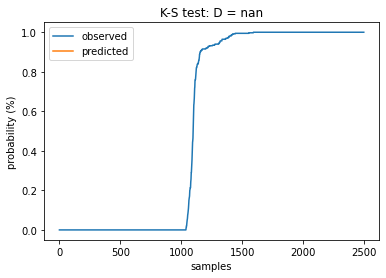

In [103]:
#ks test comparison
ks_bayes = error_ks(t_test,p2, t_op)

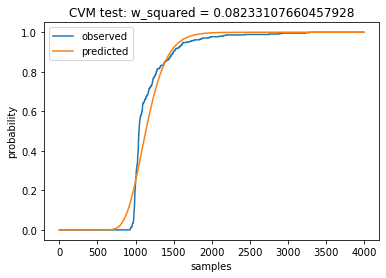

In [40]:
#cvm test comparison
cvm_bayes = error_cvm(t_test,p2, t_op)

## 3b) With offset

count: 9
count: 9
0.43139627174895423 0.05706259411803464
0.4595261185701571 0.06042259852719297


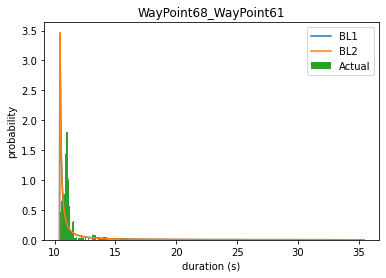

In [104]:
#Plot against actual data
offset = np.min(t_op) - 0.001
t_obs = t_op - offset

t_start= 0.0001
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.0001
t_test = np.arange(t_start,t_stop,t_step)

#prior hyperparameters
a = 1
b = 1
c = 1
d = 1
e = 1

#alpha, beta = Inverse_Gamma_bayes(t_obs, a, b, c, d, e)
alpha1, beta1 = Inverse_Gamma_bayes(t_obs, a, b, c, d, e)
alpha2, beta2 = Inverse_Gamma_bayes2(t_obs, w1 = 1, w2 = 1)
print(alpha1,beta1)
print(alpha2,beta2)

p1 = Inverse_Gamma(t_test, alpha1, beta1)
p2 = Inverse_Gamma(t_test, alpha2, beta2)

plt.plot(t_test+offset,p1)
plt.plot(t_test+offset,p2)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")
plt.legend(["BL1", "BL2", "Actual"])

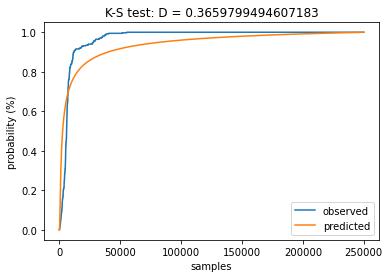

In [105]:
#ks test comparison
ks_bayes = error_ks(t_test+offset,p2, t_op)

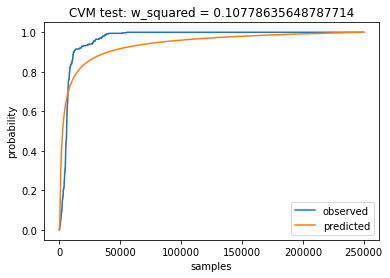

In [106]:
#cvm test comparison
cvm_bayes = error_cvm(t_test+offset,p2, t_op)

## 3c) With cutoff

count: 94
count: 2
4.371225565193057 42.27685504903804
nan nan


C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma_bayes2.py:53: RuntimeWarning: invalid value encountered in log
  k1 = n*( np.mean( -np.log(x) ) - sp.special.digamma(alpha) + np.log(n*alpha) - np.log(np.sum(1/x)) - alpha * sp.special.polygamma(1,alpha) + 1)


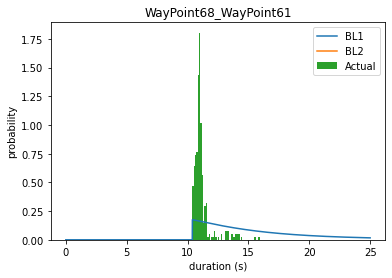

In [107]:
#Plot against actual data
offset = np.min(t_op) - 0.001
t_obs = t_op

t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#prior hyperparameters
a = 3
b = 1
c = 3
d = 4
e = 5

alpha1, beta1 = Inverse_Gamma_bayes(t_obs, a, b, c, d, e)
alpha2, beta2 = Inverse_Gamma_bayes2(t_obs, w1 = 1, w2 = 1)
print(alpha1,beta1)
print(alpha2,beta2)

p1 = Inverse_Gamma(t_test, alpha1, beta1)
p2 = Inverse_Gamma(t_test, alpha2, beta2)

p1[t_test<np.min(t_op)] = 0
#normalise
spacing = t_test[1]-t_test[0]
norm_const = spacing * np.sum(p1)
p1 /= norm_const

p2[t_test<np.min(t_op)] = 0
#normalise
spacing = t_test[1]-t_test[0]
norm_const = spacing * np.sum(p2)
p2 /= norm_const

plt.plot(t_test,p1)
plt.plot(t_test,p2)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")
plt.legend(["BL1", "BL2", "Actual"])

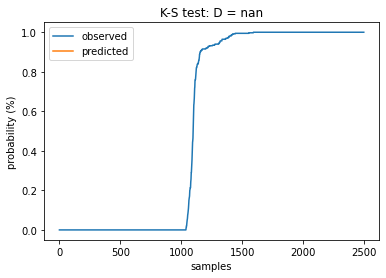

In [108]:
#ks test comparison
ks_bayes = error_ks(t_test,p2, t_op)

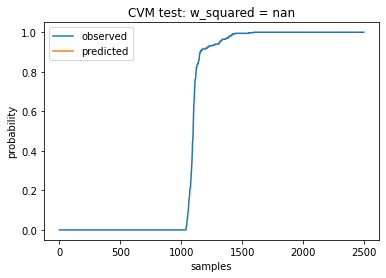

In [109]:
#cvm test comparison
cvm_bayes = error_cvm(t_test,p2, t_op)

## 3d) Compare Scipy fit
- fit returns 3 parameters
- param[0] = alpha, param[1] = offset, param[2] = beta

(134.75587332009968, 3.5818074339194563, 1011.094054881969)


C:\Users\pyliu\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma.py:30: RuntimeWarning: overflow encountered in double_scalars
  norm_const = (beta**alpha) / gamma_const
C:\Users\pyliu\Documents\GOALS\Code\Wk4\Inverse_Gamma.py:32: RuntimeWarning: invalid value encountered in multiply
  return norm_const * x ** (-alpha - 1) * np.exp(exponent)


Text(0, 0.5, 'probability')

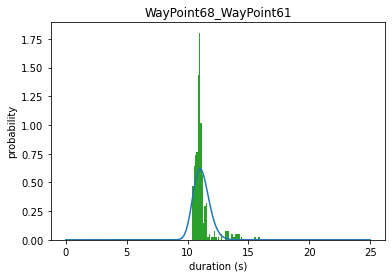

In [110]:
#compare to scipy fit
params = sp.stats.invgamma.fit(t_op)
print(params)
p_sp = sp.stats.invgamma.pdf(t_test, params[0], params[1], params[2])
p_test = Inverse_Gamma(t_test, params[0], params[2])
plt.plot(t_test,p_sp)
plt.plot(t_test+params[1],p_test)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")

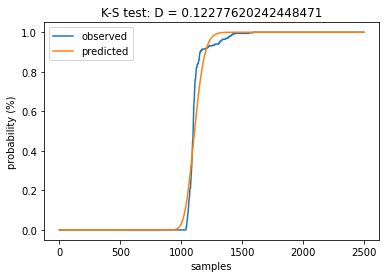

In [111]:
#ks test comparison
ks_bayes = error_ks(t_test,p_sp, t_op)

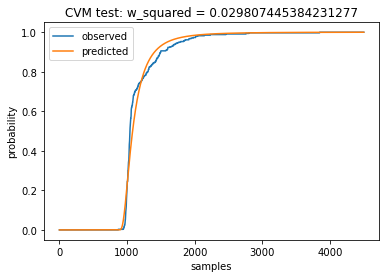

In [126]:
#cvm test comparison
cvm_sp = error_cvm(t_test,p_sp, t_op)

# 4) Inverse Gamma model
- Does not use the approximation method in part 3
- Instead use product of conjugate priors for each parameter of the Inverse Gamma distribution

In [128]:
# Select data of interest
wp1 = "WayPoint61"
wp2 = "WayPoint54"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]
print("done")

done


In [129]:
#Plot against actual data
offset = np.min(t_op) - 0.001
#offset = 0
t_obs = t_op - offset

#prior parameters
a = 1
b = 1
c = 1
d = 1
e = 1


alpha_map, beta_map = Inverse_Gamma_bayes3(t_obs, a, b, c, d, e)
print(alpha_map, beta_map)

64 MAP probability above threshold
0.5 0.1


Text(0, 0.5, 'probability')

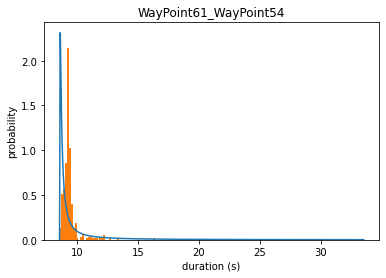

In [130]:

#Plot against actual data

t_start= 0.001
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.001
t_test = np.arange(t_start,t_stop,t_step)

p_bayes = Inverse_Gamma(t_test, alpha= alpha_map, beta = beta_map)

#p_bayes[t_test<np.min(t_op)] = 0
#normalise
#spacing = t_test[1]-t_test[0]
#norm_const = spacing * np.sum(p_bayes)
#p_bayes /= norm_const

plt.plot(t_test+offset,p_bayes)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")

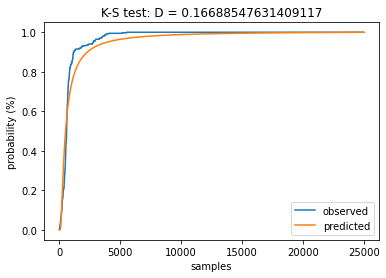

In [118]:
#ks test comparison
ks_bayes = error_ks(t_test+offset,p_bayes, t_op)

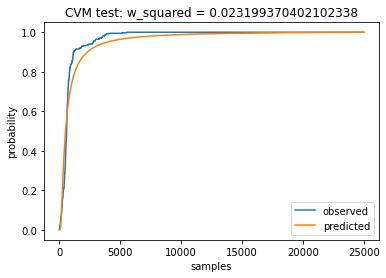

In [119]:
#cvm test comparison
cvm_bayes = error_cvm(t_test+offset,p_bayes, t_op)

# 5) Inverse Gaussian model
- See Pandee_InverseGaussian for conjugate prior

Key issue: for some reason, when using a Gaussian likelihood in the optimisation, the parameters fit the corresponding Inverse Gaussian distribution well.

## 5a) Bayesian fitting

In [131]:
# Select data of interest
wp1 = "WayPoint61"
wp2 = "WayPoint54"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]
print("done")

done


In [132]:
#define hyperparameters
a = 1
b = 1
c = 1
d = 1

#shift data
offset = np.min(t_op) - 0.001
#offset = 0
t_obs = t_op - offset

tic = time.time()
mu_map,L_map = Inverse_Gaussian_bayes(t_obs, a, b, c, d, threshold = 0.9)
toc = time.time()


print("Time take:", toc-tic, "secs")
print("mu_MAP:",mu_map,"   L_MAP:",L_map)
    

61 MAP probability above threshold
Time take: 1.2652630805969238 secs
mu_MAP: 0.8    L_MAP: 1.1


Text(0, 0.5, 'probability')

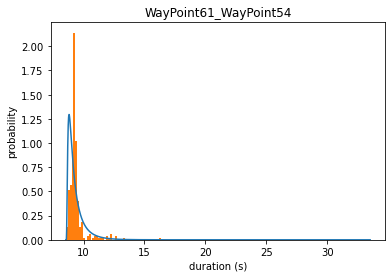

In [133]:
#Plot against actual data

t_start= 0.01
t_stop = (np.max(t_op)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

p_bayes = Inverse_Gaussian(t_test, mu = mu_map, L = 1/L_map)
plt.plot(t_test+offset,p_bayes)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")

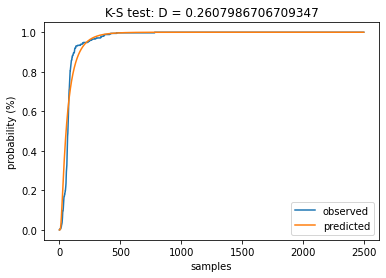

In [134]:
#ks test comparison
ks_bayes = error_ks(t_test+offset,p_bayes, t_op)

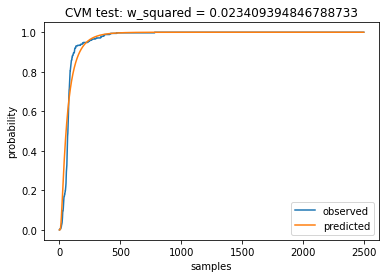

In [135]:
#cvm test comparison
cvm_bayes = error_cvm(t_test+offset,p_bayes, t_op)

## 5b) Scipy fit

(0.31142350057737206, 8.397983350982468, 3.150783949719046)


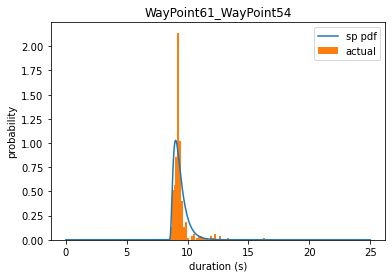

In [136]:
params = sp.stats.invgauss.fit(t_op)
print(params)

p_sp = sp.stats.invgauss.pdf(t_test, params[0], params[1], params[2])

plt.plot(t_test,p_sp)
plt.hist(t_op, density = True, bins = 50);

plt.title(edge)
plt.xlabel("duration (s)")
plt.ylabel("probability")

plt.legend(["sp pdf", "actual"])


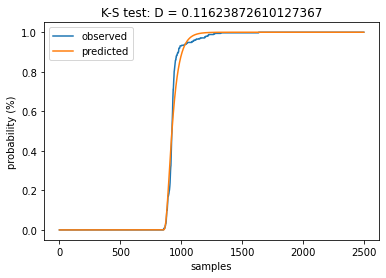

In [137]:
#ks test comparison
ks_bayes = error_ks(t_test,p_sp, t_op)

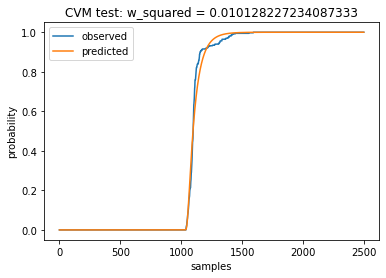

In [127]:
#cvm test comparison
cvm_sp = error_cvm(t_test,p_sp, t_op)

# 6) Similarity of edges

## 6a) Between a pair of edges

In [18]:
# Select data of interest
wp1 = "WayPoint69"
wp2 = "WayPoint70"
edge = wp1 + "_" + wp2
subset1 = select_data_edge(df, edge)
#independent variable to plot over
t_op1 = subset1["operation_time"]
print("done")

done


In [36]:
# Select data of interest
wp1 = "WayPoint70"
wp2 = "WayPoint69"
edge = wp1 + "_" + wp2
subset2 = select_data_edge(df, edge)
#independent variable to plot over
t_op2 = subset2["operation_time"]
print("done")

done


In [37]:
stat = sp.stats.ks_2samp(t_op1,t_op2)
print(stat)
print("Statistic:", stat[0], "   P-val:", stat[1])

KstestResult(statistic=0.24120951751487113, pvalue=3.9081663127937816e-08)
Statistic: 0.24120951751487113    P-val: 3.9081663127937816e-08


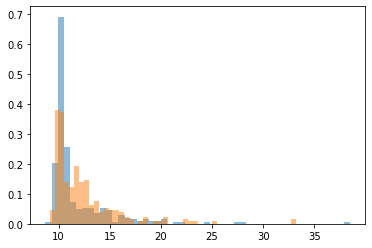

In [38]:
plt.hist(t_op1, density = True, bins = 50, alpha = 0.5);
plt.hist(t_op2, density = True, bins = 50, alpha = 0.5);

## 6b) Between all edges

In [60]:
similar_edges = ks_between_edges(df, threshold = 0.10, min_samples = 25, similar = True)
print(len(similar_edges))

Time taken: 12.368208408355713 secs
93


In [61]:
similar_edges = similar_edges.sort_values("ks_statistic", ascending = True)
similar_edges.head()

,edge_1,edge_2,count_1,count_2,ks_statistic,p_value
3,WayPoint70_WayPoint69,WayPoint72_WayPoint71,267,308,0.051073,0.824342
1,WayPoint71_WayPoint72,WayPoint70_WayPoint71,334,443,0.052189,0.651786
5,WayPoint67_WayPoint74,WayPoint53_WayPoint60,181,232,0.057273,0.867162
0,WayPoint69_WayPoint70,WayPoint70_WayPoint71,340,443,0.058644,0.498514
11,WayPoint102_WayPoint95,WayPoint95_WayPoint102,125,139,0.066993,0.901941


In [62]:
similar_edges = similar_edges.sort_values("p_value", ascending = False)
similar_edges.head()

,edge_1,edge_2,count_1,count_2,ks_statistic,p_value
60,WayPoint92_WayPoint93,WayPoint48_WayPoint49,33,60,0.080303,0.996379
25,WayPoint95_WayPoint88,WayPoint88_WayPoint95,59,61,0.085857,0.960384
21,WayPoint49_WayPoint50,WayPoint51_WayPoint52,60,60,0.100000,0.928437
56,WayPoint81_WayPoint88,WayPoint54_WayPoint47,37,60,0.105856,0.927593
91,WayPoint97_WayPoint98,WayPoint99_WayPoint100,26,26,0.153846,0.926019


In [63]:
#Save to excel
similar_edges.to_excel("similar_edges.xlsx")
print("done")

done


In [64]:
#retrieve from excel
similar_edges = pd.read_excel("similar_edges.xlsx")
similar_edges = similar_edges[["edge_1", "edge_2","count_1","count_2", "ks_statistic","p_value"]]
print("done")

done


## 6c) Get information from topological map
Extract relevant data from YAML file, then infer edge length and number of connections at each node. Finally, store as a dataframe - columns are:
- edge_id (forward and backward are not the same)
- origin node
- target node
- edge_length
- branches at origin node
- branches at target node

In [65]:
context = get_context(filename = "walmart_map.yaml")
context.head()

,edge_id,origin,target,edge_length,n_connections_origin,n_connections_target
0,WayPoint1_WayPoint2,WayPoint1,WayPoint2,5.50815,2,2
1,WayPoint1_WayPoint7,WayPoint1,WayPoint7,4.9098,2,3
2,WayPoint10_WayPoint9,WayPoint10,WayPoint9,5.50465,2,2
3,WayPoint10_WayPoint11,WayPoint10,WayPoint11,5.50465,2,2
4,WayPoint100_WayPoint101,WayPoint100,WayPoint101,5.50465,2,2


In [66]:
#save to excel
context.to_excel("context.xlsx")
print("done")

done


## 6d) Augment similar_edges with context

In [67]:
similar_edges = augment_with_context(similar_edges, context)
similar_edges.head()

,edge_1,edge_2,count_1,count_2,ks_statistic,p_value,edge_length_1,edge_length_2,origin_connections_1,origin_connections_2,target_connections_1,target_connections_2,length_diff,origin_connections_diff,target_connections_diff
0,WayPoint92_WayPoint93,WayPoint48_WayPoint49,33,60,0.080303,0.996379,5.50465,5.50465,2,2,2,2,3.55271e-15,0,0
1,WayPoint95_WayPoint88,WayPoint88_WayPoint95,59,61,0.085857,0.960384,6.89378,6.89378,3,3,3,3,0,0,0
2,WayPoint49_WayPoint50,WayPoint51_WayPoint52,60,60,0.100000,0.928437,5.50465,5.50465,2,2,2,2,3.22e-08,0,0
3,WayPoint81_WayPoint88,WayPoint54_WayPoint47,37,60,0.105856,0.927593,5.90828,5.8931,3,3,3,3,0.0151824,0,0
4,WayPoint97_WayPoint98,WayPoint99_WayPoint100,26,26,0.153846,0.926019,5.50465,5.50465,2,2,2,2,3.55271e-15,0,0


In [68]:
#save to excel
similar_edges.to_excel("similar_edges_with_context.xlsx")
print("done")

done


## 6e) compare to dissimilar edges

In [11]:
dissimilar_edges = ks_between_edges(df, threshold = 0.01, min_samples = 25, similar = False)
print(len(dissimilar_edges))

Time taken: 12.275880336761475 secs
1992


In [13]:
context = get_context(filename = "walmart_map.yaml")
dissimilar_edges = augment_with_context(dissimilar_edges, context)
dissimilar_edges.head()

,edge_1,edge_2,count_1,count_2,ks_statistic,p_value,edge_length_1,edge_length_2,origin_connections_1,origin_connections_2,target_connections_1,target_connections_2,length_diff,origin_connections_diff,target_connections_diff
15,WayPoint69_WayPoint68,WayPoint70_WayPoint71,268,443,0.137529,0.003180,5.50815,5.50465,2,2,4,2,0.00350052,0,2
8,WayPoint72_WayPoint71,WayPoint71_WayPoint72,308,334,0.146357,0.001805,5.50465,5.50465,2,2,2,2,0,0,0
55,WayPoint60_WayPoint67,WayPoint46_WayPoint53,236,238,0.150442,0.008140,4.9307,4.84703,3,3,3,3,0.0836767,0,0
2,WayPoint69_WayPoint70,WayPoint68_WayPoint69,340,353,0.154874,0.000418,5.50465,5.50815,2,4,2,2,0.00350052,2,0
177,WayPoint73_WayPoint72,WayPoint70_WayPoint71,150,443,0.156403,0.007232,5.50465,5.50465,2,2,2,2,3.22e-08,0,0


In [15]:
#save to excel
dissimilar_edges.to_excel("dissimilar_edges_with_context.xlsx")
print("done")

done


# 7) Topological maps

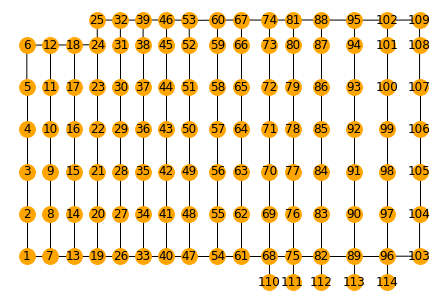

In [4]:
G = draw_graph(filename = "walmart_map.yaml")

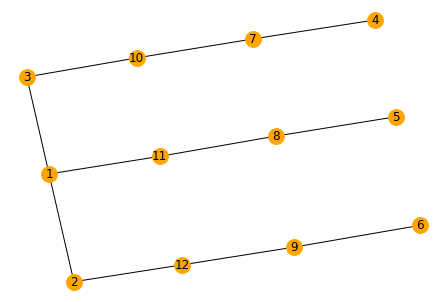

In [5]:
G = draw_graph(filename = "blenheim_map.yaml")

# 8) Generalise between edges
- lognormal fitting

In [40]:
# Select data of interest - edge 1
wp1 = "WayPoint70"
wp2 = "WayPoint69"
edge1 = wp1 + "_" + wp2
subset1 = select_data_edge(df, edge1)
#independent variable to plot over
t_op1 = subset1["operation_time"]

# Select data of interest - edge 2
wp1 = "WayPoint71"
wp2 = "WayPoint72"
edge2 = wp1 + "_" + wp2
subset2 = select_data_edge(df, edge2)
#independent variable to plot over
t_op2 = subset2["operation_time"]

print("done")

done


MAP mean: 0.751     MAP var: 0.988
Time for calculation: 54.14895415306091 secs


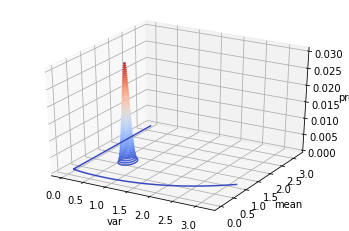

In [41]:
# fit to data of first
#use offset and take log of data
offset = np.min(t_op1) - 0.001
t_log = np.log(t_op1 - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test1, var_test1, posterior1, mean_map1, var_map1 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map1, "    MAP var:", var_map1)
print("Time for calculation:", toc-tic, "secs")


MAP mean: 0.781     MAP var: 0.772
Time for calculation: 64.99609541893005 secs


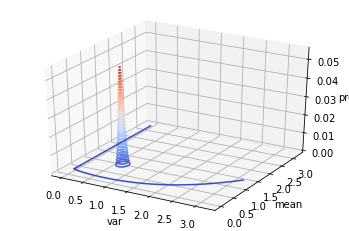

In [42]:
# fit to data for second edge
#use offset and take log of data
offset = np.min(t_op2) - 0.001
t_log = np.log(t_op2 - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test2, var_test2, posterior2, mean_map2, var_map2 = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map2, "    MAP var:", var_map2)
print("Time for calculation:", toc-tic, "secs")

Text(0.5, 1.0, 'WayPoint71_WayPoint72')

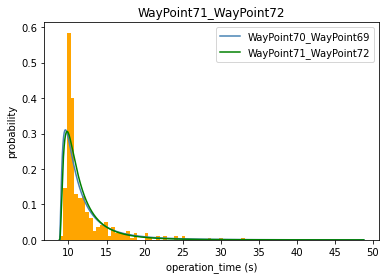

In [43]:
#Plot against data for second edge

t_start= 0.01
t_stop = (np.max(t_op2)//5)*5 + 10    #round up to nearest 5 secs
t_step = 0.01
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes1 = Lognormal(t_test,mean_map1,var_map1)
p_bayes2 = Lognormal(t_test,mean_map2,var_map2)

#plot
plt.plot(t_test+offset,p_bayes1, color = "steelblue", alpha = 1)
plt.plot(t_test+offset,p_bayes2, color = "green", alpha = 1)
plt.hist(t_op2, density = True, bins = 50, color = "orange")

plt.legend([edge1, edge2])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge2)

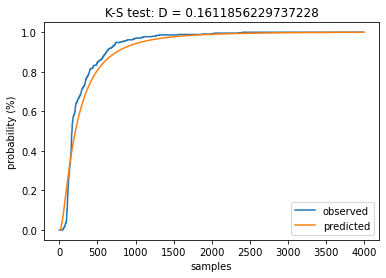

In [44]:
#ks test comparison
#different edges
ks_bayes = error_ks(t_test+offset,p_bayes1, t_op)

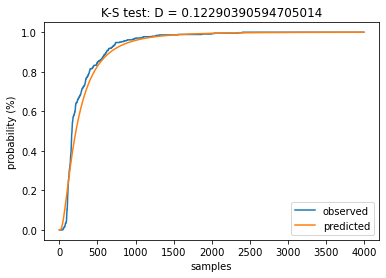

In [45]:
#ks test comparison
#same edge
ks_bayes = error_ks(t_test+offset,p_bayes2, t_op)

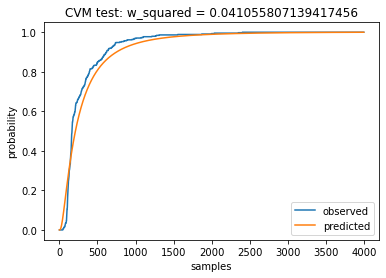

In [46]:
#cvm test comparison
#different edges
cvm_ml = error_cvm(t_test+offset,p_bayes1, t_op)

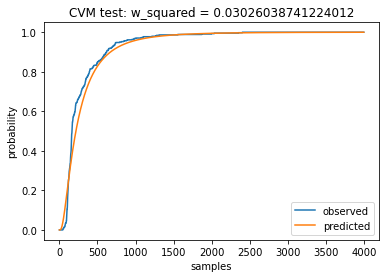

In [47]:
#cvm test comparison
#same edge
cvm_ml = error_cvm(t_test+offset,p_bayes2, t_op)